In [1]:
# Imports.
import torch
import torch.nn as nn 
from torchvision import transforms
import numpy as np
from  matplotlib import pyplot as plt
import torch.nn.functional as F
import time
from utils import get_data, show_img

In [2]:
# Class for storing things such as learning rate, image size...
class Args:
    def __init__(self):
        self.lr = 2e-4
        self.epochs = 10
        self.b1 = 0.5
        self.b2 = 0.999
        self.latent_dim = 512
        self.img_size = 128
        self.pixels = int(self.img_size ** 2)
        self.channels = 3
        self.img_tuple = (self.channels, self.img_size, self.img_size)
        self.batch_size = 32

In [3]:
# Loading the images.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = Args()
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((args.img_size, args.img_size)),
                                transforms.Normalize(mean=0, std=1)])
paintings, photos, painting_loader, photo_loader = get_data(transform=transform, batch_size=32)

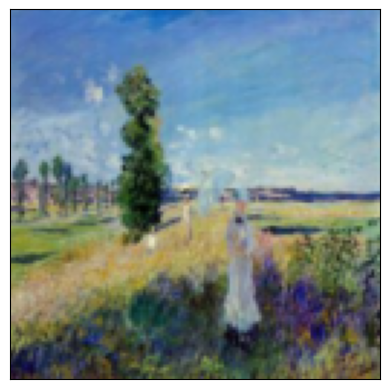

In [4]:
show_img(paintings[100])

In [11]:
# Defining the models. 
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.lin1 = nn.Linear(in_channels, 128)
        self.lin2 = nn.Linear(128, 256)
        self.lin3 = nn.Linear(256, 512)
        self.lin4 = nn.Linear(512, 1024)
        self.lin5  = nn.Linear(1024, out_channels)
        self.norm1 = nn.BatchNorm1d(256, 0.8)
        self.norm2 = nn.BatchNorm1d(512, 0.8)
        self.norm3  = nn.BatchNorm1d(1024, 0.8)

    def forward(self, noise_vector):
        x = self.lin1(noise_vector)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.lin2(x)
        x = self.norm1(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.lin3(x)
        x = self.norm2(x)
        x = self.lin4(x)
        x = self.norm3(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.lin5(x)
        x = F.tanh(x)
        return x.view(x.size(0), *args.img_tuple)

class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin1 = nn.Linear(in_channels, 512)
        self.lin2 = nn.Linear(512, 256)
        self.lin3 = nn.Linear(256, 1)

    def forward(self, image):
        x = image.view(image.size(0), -1)
        x = self.lin1(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.lin2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.lin3(x)
        return F.sigmoid(x)

In [13]:
#  Main loop.
generator = Generator(args.latent_dim, args.pixels * args.channels).to(device)
discriminator = Discriminator(args.pixels * args.channels).to(device)
loss_fn = nn.BCELoss()
g_optim = torch.optim.Adam(generator.parameters(), lr=args.lr, betas=(args.b1, args.b2))
d_optim = torch.optim.Adam(discriminator.parameters(), lr=args.lr, betas=(args.b1, args.b2))
g_loss_list, d_loss_list = [], []

for epoch in range(1, args.epochs + 1):
    g_epoch_loss = 0
    d_epoch_loss = 0
    t = time.time()
    for i, images in enumerate(painting_loader):
        # Getting our data.
        noise_vector = torch.randn(images.size(0), args.latent_dim).to(device)
        images = images.to(device)
        real_target = torch.ones(images.size(0), 1).to(device)
        fake_target = torch.zeros(images.size(0), 1).to(device)

        # Training the discriminator. 
        d_optim.zero_grad()
        d_real_out = discriminator(images)
        d_real_loss = loss_fn(d_real_out, real_target)
        d_fake_out = discriminator(generator(noise_vector))
        d_fake_loss = loss_fn(d_fake_out, fake_target)
        d_loss = d_real_loss + d_fake_loss
        d_epoch_loss += d_loss.item()
        d_loss.backward()
        d_optim.step()

        # Training the generator. 
        g_optim.zero_grad()
        g_out = generator(noise_vector)
        g_loss = loss_fn(discriminator(g_out), real_target)
        g_epoch_loss += g_loss.item()
        g_loss.backward()
        g_optim.step()
    
    g_epoch_loss /= len(painting_loader)
    d_epoch_loss /= len(painting_loader)
    print(f"EPOCH: {epoch}\nExecution time: {time.time() - t:.1f} sec.\nGenerator loss: {g_epoch_loss:.3f}\nDiscriminator loss: {d_epoch_loss:.3f}\n")
    g_loss_list.append(g_epoch_loss)
    d_loss_list.append(d_epoch_loss)

In [ ]:
plt.plot(g_loss_list, label="Generator loss")
plt.plot(d_loss_list, label="Discriminator loss")
plt.legend()
plt.show()